In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [27]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\Users\Keshav\OneDrive\Desktop\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [28]:
mask_img = mpimg.imread(DIRECTORY + r"\with_mask\0_0_0 copy 66.jpg")

height, width, channels = mask_img.shape
print(f"WithMask\nWidth: {width}, Height: {height}, Channels: {channels}\n")

WithMask
Width: 169, Height: 244, Channels: 3



In [29]:
withoutmask_img = mpimg.imread(DIRECTORY + r"\without_mask\0_0_anhu_0189.jpg")

height, width, channels = withoutmask_img.shape
print(f"WithoutMask\nWidth: {width}, Height: {height}, Channels: {channels}\n")

WithoutMask
Width: 160, Height: 131, Channels: 3



In [30]:
import os
import matplotlib.pyplot as plt

values = []

for category in CATEGORIES:
    # Directory containing images
    print(category)
    image_directory = DIRECTORY + "\\" + category
    # CSV file to save the dimensions
    csv_file = 'image_dimensions.csv'

    # List to store image data
    image_data = []

    # Iterate through all files in the directory
    for filename in os.listdir(image_directory):
        filepath = os.path.join(image_directory, filename)
        try:
            image = plt.imread(filepath)
            height, width, _ = image.shape
            image_data.append([filename, width, height])
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

    values.append(len(image_data))
    print(image_data)

with_mask
[['0_0_0 copy 10.jpg', 66, 92], ['0_0_0 copy 11.jpg', 102, 128], ['0_0_0 copy 12.jpg', 99, 147], ['0_0_0 copy 13.jpg', 141, 214], ['0_0_0 copy 14.jpg', 138, 169], ['0_0_0 copy 15.jpg', 98, 138], ['0_0_0 copy 16.jpg', 422, 637], ['0_0_0 copy 17.jpg', 135, 218], ['0_0_0 copy 18.jpg', 177, 204], ['0_0_0 copy 19.jpg', 112, 188], ['0_0_0 copy 2 2.jpg', 173, 268], ['0_0_0 copy 2.jpg', 168, 283], ['0_0_0 copy 2.png', 50, 84], ['0_0_0 copy 20.jpg', 131, 180], ['0_0_0 copy 21.jpg', 86, 121], ['0_0_0 copy 22.jpg', 135, 208], ['0_0_0 copy 23.jpg', 119, 170], ['0_0_0 copy 24.jpg', 122, 207], ['0_0_0 copy 25.jpg', 306, 482], ['0_0_0 copy 26.jpg', 197, 342], ['0_0_0 copy 27.jpg', 722, 600], ['0_0_0 copy 28.jpg', 84, 123], ['0_0_0 copy 29.jpg', 623, 1042], ['0_0_0 copy 3 2.jpg', 185, 268], ['0_0_0 copy 3.jpg', 67, 81], ['0_0_0 copy 3.png', 207, 325], ['0_0_0 copy 30.jpg', 203, 281], ['0_0_0 copy 31.jpg', 123, 196], ['0_0_0 copy 32.jpg', 64, 82], ['0_0_0 copy 33.jpg', 145, 193], ['0_0_0 copy

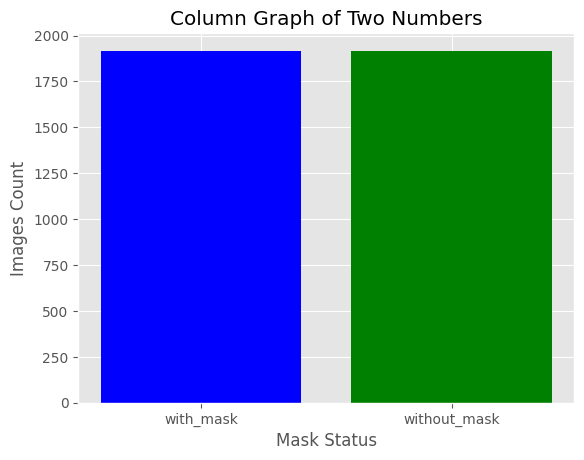

In [31]:
# Define your data
labels = ['with_mask', 'without_mask']  # Names for your two values

# Create a bar chart
plt.bar(labels, values, color=['blue', 'green'])

# Add title and labels
plt.xlabel('Mask Status')
plt.ylabel('Images Count')

# Show the plot
plt.show()


In [32]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


c:\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [33]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [34]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [35]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

C:\Users\Keshav\AppData\Local\Temp\ipykernel_11384\4269477345.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


In [36]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [37]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [38]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


c:\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [39]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=aug.flow(testX, testY, batch_size=BS),  # Use data augmentation for validation
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 79s 771ms/step - accuracy: 0.7136 - loss: 0.5950 - val_accuracy: 0.9851 - val_loss: 0.1422
Epoch 2/20
 1/95 ━━━━━━━━━━━━━━━━━━━━ 46s 491ms/step - accuracy: 0.8438 - loss: 0.3039

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8438 - loss: 0.3039 - val_accuracy: 0.9677 - val_loss: 0.2101
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 68s 700ms/step - accuracy: 0.9601 - loss: 0.1683 - val_accuracy: 0.9905 - val_loss: 0.0775
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9375 - loss: 0.1044 - val_accuracy: 1.0000 - val_loss: 0.0850
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 68s 706ms/step - accuracy: 0.9731 - loss: 0.1035 - val_accuracy: 0.9905 - val_loss: 0.0465
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0464 - val_accuracy: 0.9677 - val_loss: 0.1090
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 69s 715ms/step - accuracy: 0.9785 - loss: 0.0794 - val_accuracy: 0.9918 - val_loss: 0.0425
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9375 - loss: 0.1066 - val_accuracy: 1.0000 - val_loss: 0.0340
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 69s 712ms/step - accuracy: 0.9713 - loss: 0.0802 - val_accuracy: 0.9891 - val_loss

In [40]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 517ms/step


In [41]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



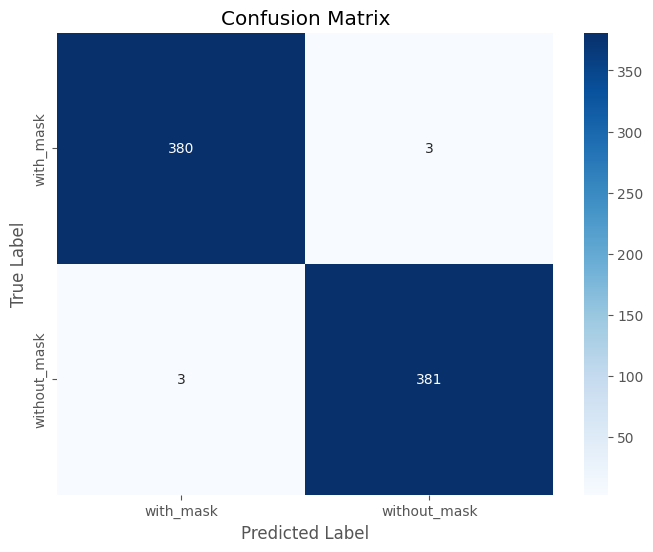

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(testY.argmax(axis=1), predIdxs)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

[INFO] saving mask detector model...


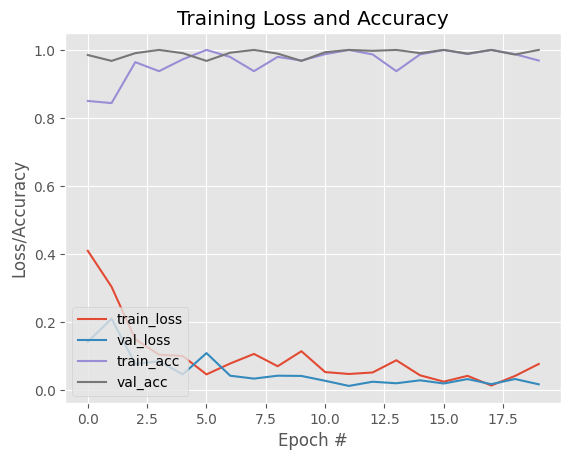

: 

In [43]:

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.h5", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")